In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
from pathlib import Path

import torch
from datasets import Dataset, DatasetDict, load_dataset
from torch import Tensor, nn
from tqdm import tqdm
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

from luminar.classifier import LuminarCNN, LuminarCNN2D
from luminar.classifier import ConvolutionalLayerSpec
from luminar.utils import PaddingDataCollator, get_matched_datasets


HF_TOKEN = (Path.home() / ".hf_token").read_text().strip()

### Encoder

In [ ]:
# from luminar.encoder import LuminarEncoder


# encoder = LuminarEncoder()
# encoder.device = "cuda:0"

### Classifier

In [ ]:
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     scores = torch.tensor(logits).sigmoid().cpu().flatten().numpy()
#     labels = np.array(labels).flatten()

#     metrics = {}

#     metrics["acc"] = float(accuracy_score(labels, scores > 0.5))
#     metrics["f1"] = float(f1_score(labels, scores > 0.5))

#     threshold = sorted(scores)[len(labels) - sum(labels) - 1]
#     metrics["acc_calibrated"] = float(accuracy_score(labels, scores > threshold))
#     metrics["f1_calibrated"] = float(f1_score(labels, scores > threshold))
#     metrics["threshold"] = threshold

#     if sum(labels) == 0 or sum(labels) == len(labels):
#         auroc = -1
#     else:
#         auroc = float(roc_auc_score(labels, scores))
#     metrics["auroc"] = auroc

#     return metrics

In [ ]:
import evaluate
import numpy as np
from numpy.typing import NDArray

acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")
roc_auc = evaluate.load("roc_auc")


def compute_scores(preds: NDArray, labels: NDArray, suffix=""):
    f1_score_each = f1.compute(predictions=preds, references=labels, average=None)
    f1_score_weighted = f1.compute(
        predictions=preds, references=labels, average="weighted"
    )
    acc_score = acc.compute(predictions=preds, references=labels)
    roc_auc_score = roc_auc.compute(prediction_scores=preds, references=labels)

    return {
        f"f1_human{suffix}": f1_score_each["f1"][0],  # type: ignore
        f"f1_ai{suffix}": f1_score_each["f1"][1],  # type: ignore
        f"f1_weighted{suffix}": f1_score_weighted["f1"],  # type: ignore
        f"accuracy{suffix}": acc_score["accuracy"],  # type: ignore
        f"roc_auc{suffix}": roc_auc_score["roc_auc"],  # type: ignore
    }


def compute_metrics(eval_pred):
    logits, labels = eval_pred

    labels = np.array(labels)
    scores = 1 / (1 + np.exp(-np.array(logits)))

    metrics = compute_scores(scores > 0.5, labels)

    gt_0 = np.sum(labels == 0)
    gt_1 = np.sum(labels == 1)

    if gt_0 == gt_1:
        # dataset is balanced, use the median of all scores as threshold
        threshold = np.median(scores)
        metrics |= compute_scores(scores > threshold, labels, "_median")
        metrics["threshold_median"] = threshold
    elif gt_0 > 0 < gt_1:
        # dataset is unbalanced, use the midpoint between the means of the two classes as threshold
        threshold = float(scores[labels == 0].mean() + scores[labels == 1].mean()) / 2
        metrics |= compute_scores(scores > threshold, labels, "_mean")
        metrics["threshold_mean"] = threshold
    else:
        # only one class is present
        # TODO?
        pass

    metrics["ground_truth_human"] = gt_0
    metrics["ground_truth_ai"] = gt_1

    return metrics

In [ ]:
from hashlib import sha256
import json


def save_model(trainer: Trainer, config: dict):
    config_str = json.dumps(config, indent=4, sort_keys=True)
    config_hash = sha256(config_str.encode()).hexdigest()[:10]

    path = Path(
        f"../models/luminar_cnn/{config['domain']}-{config['agent']}-gpt2_256-{config_hash}/"
    )

    trainer.save_model(str(path))

    with (path / "pytorch_model.bin").open("wb") as fp:
        torch.save(trainer.model, fp)

    with (path / "config.json").open("w") as fp:
        fp.write(config_str)

In [ ]:
agent = "gpt_4o_mini"
other_agents = "gemma2_9b"
domain = "student_essays"
feature_len = 256
seed = 42

In [ ]:
def pad_to_fixed_length(x: NDArray) -> NDArray:
    size = x.shape[0]
    if size < feature_len:
        return np.pad(x, ((0, feature_len - size), (0, 0)), mode="constant")
    else:
        return x[:feature_len]

In [ ]:
dataset: Dataset = (
    load_dataset(
        "liberi-luminaris/PrismAI-encoded-gpt2",
        f"{domain}-fulltext",
        split=f"human+{agent}+{other_agents}",
        token=HF_TOKEN,
    )  # type: ignore
    .rename_column("label", "labels")
    .with_format("numpy", columns=["features"])
    .map(
        lambda features: {"features": pad_to_fixed_length(features)},
        input_columns=["features"],
        desc="Trimming & Padding Features",
    )
)

In [ ]:
datasets_matched = get_matched_datasets(dataset, agent)
datasets_matched.set_format("torch", columns=["labels", "features"])

In [ ]:
config = {
    # first 256 features & 13 layers for gpt2
    "feature_dim": (feature_len, 13),
    "feature_type": "intermediate_likelihoods",
    "feature_selection": "first",
    "conv_layer_shapes": (
        ConvolutionalLayerSpec(32, 5),
        ConvolutionalLayerSpec(64, 5),
        ConvolutionalLayerSpec(32, 3),
    ),
    "projection_dim": (1024, 32),
    "learning_rate": 5e-4,
    "max_epochs": 10,
    "gradient_clip_val": 1.0,
    "train_batch_size": 32,
    "eval_batch_size": 1024,
    "warmup_ratio": 1.0,
    "seed": seed,
    "agent": agent,
    "domain": domain,
}

In [ ]:
training_args = TrainingArguments(
    output_dir="logs/hf/",
    per_device_train_batch_size=config["train_batch_size"],
    per_device_eval_batch_size=config["eval_batch_size"],
    learning_rate=config["learning_rate"],
    num_train_epochs=config["max_epochs"],
    warmup_ratio=config["warmup_ratio"],
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    torch_compile=True,
    torch_compile_mode="reduce-overhead",
)

In [118]:
classifier = LuminarCNN(**config)
classifier.forward(
    torch.randn(config["train_batch_size"], *config["feature_dim"]),
    labels=torch.randint(0, 2, (config["train_batch_size"],)),
)
classifier.to("cuda:0")
print(classifier)
print(
    "Parameters:\n  conv_layers:",
    sum(
        param.numel()
        for param in classifier.conv_layers.parameters()
        if param.requires_grad
    ),
    "\n  projection:",
    sum(
        param.numel()
        for param in classifier.projection.parameters()
        if param.requires_grad
    ),
    "\n  classifier:",
    sum(
        param.numel()
        for param in classifier.classifier.parameters()
        if param.requires_grad
    ),
    "\n  total:",
    sum(param.numel() for param in classifier.parameters() if param.requires_grad),
)

LuminarCNN(
  (conv_layers): Sequential(
    (0): Conv1d(13, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (projection): Sequential(
    (0): Linear(in_features=32, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=32, bias=True)
    (3): SiLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=8192, out_features=1, bias=True)
  (criterion): BCEWithLogitsLoss()
)
Parameters:
  conv_layers: 18592 
  projection: 66592 
  classifier: 8193 
  total: 93377


In [ ]:
# conv_layer_spec = (
#     ConvolutionalLayerSpec(8, (7, 1)),
#     ConvolutionalLayerSpec(16, (7, 1)),
#     ConvolutionalLayerSpec(32, 7),
#     ConvolutionalLayerSpec(64, 5),
#     ConvolutionalLayerSpec(32, 3),
#     ConvolutionalLayerSpec(3, 3),
# )

# classifier = LuminarCNN2D(conv_layer_shapes=conv_layer_spec, **config)
# print(classifier)
# print("num. parameters:", sum(1 for p in classifier.parameters() if p.requires_grad))

In [119]:
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=datasets_matched["train"],
    eval_dataset=datasets_matched["eval"],
    # data_collator=PaddingDataCollator(config["feature_dim"]),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(5)],
)

In [120]:
trainer.train()

Step,Training Loss,Validation Loss,F1 Human,F1 Ai,F1 Weighted,Accuracy,Roc Auc,F1 Human Median,F1 Ai Median,F1 Weighted Median,Accuracy Median,Roc Auc Median,Threshold Median,Ground Truth Human,Ground Truth Ai
100,0.693200,0.693144,0.000000,0.666667,0.333333,0.500000,0.500000,0.517722,0.517322,0.517522,0.517522,0.517522,0.501716,3624,3624
200,0.693200,0.693117,0.666667,0.000000,0.333333,0.500000,0.500000,0.547110,0.546985,0.547047,0.547047,0.547047,0.497817,3624,3624
300,0.693100,0.693154,0.000000,0.666667,0.333333,0.500000,0.500000,0.575055,0.575055,0.575055,0.575055,0.575055,0.506247,3624,3624
400,0.693200,0.693003,0.666667,0.000000,0.333333,0.500000,0.500000,0.663355,0.663355,0.663355,0.663355,0.663355,0.495481,3624,3624
500,0.693100,0.692652,0.731455,0.548983,0.640219,0.663355,0.663355,0.733996,0.733996,0.733996,0.733996,0.733996,0.499697,3624,3624
600,0.692000,0.690823,0.000000,0.666667,0.333333,0.500000,0.500000,0.789735,0.789735,0.789735,0.789735,0.789735,0.512155,3624,3624
700,0.684600,0.673515,0.211765,0.691244,0.451504,0.556291,0.556291,0.813190,0.813190,0.813190,0.813190,0.813190,0.531963,3624,3624
800,0.626400,0.553054,0.716383,0.803828,0.760105,0.768074,0.768074,0.831402,0.831402,0.831402,0.831402,0.831402,0.582154,3624,3624
900,0.466300,0.410491,0.846840,0.835124,0.840982,0.841198,0.841198,0.850717,0.850717,0.850717,0.850717,0.850717,0.459242,3624,3624
1000,0.366600,0.368611,0.853177,0.842947,0.848062,0.848234,0.848234,0.858168,0.858168,0.858168,0.858168,0.858168,0.437583,3624,3624


TrainOutput(global_step=6400, training_loss=0.3064355859160423, metrics={'train_runtime': 1172.7258, 'train_samples_per_second': 432.616, 'train_steps_per_second': 13.524, 'total_flos': 0.0, 'train_loss': 0.3064355859160423, 'epoch': 4.03530895334174})

In [121]:
trainer._load_best_model()
save_model(trainer, config)

In [122]:
trainer.evaluate()

{'eval_loss': 0.15857236087322235,
 'eval_f1_human': 0.9358131729827996,
 'eval_f1_ai': 0.9375085091899251,
 'eval_f1_weighted': 0.9366608410863624,
 'eval_accuracy': 0.9366721854304636,
 'eval_roc_auc': 0.9366721854304636,
 'eval_f1_human_median': 0.9379139072847682,
 'eval_f1_ai_median': 0.9379139072847682,
 'eval_f1_weighted_median': 0.9379139072847682,
 'eval_accuracy_median': 0.9379139072847682,
 'eval_roc_auc_median': 0.9379139072847682,
 'eval_threshold_median': 0.5938345193862915,
 'eval_ground_truth_human': 3624,
 'eval_ground_truth_ai': 3624,
 'eval_runtime': 12.2504,
 'eval_samples_per_second': 591.653,
 'eval_steps_per_second': 0.653,
 'epoch': 4.03530895334174}

In [123]:
trainer.evaluate(datasets_matched["test"], metric_key_prefix="test")

early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{'test_loss': 0.1477530151605606,
 'test_f1_human': 0.9416870843542177,
 'test_f1_ai': 0.9433603046168492,
 'test_f1_weighted': 0.9425236944855334,
 'test_accuracy': 0.9425358719646799,
 'test_roc_auc': 0.94253587196468,
 'test_f1_human_median': 0.9455097254793765,
 'test_f1_ai_median': 0.9454946874568787,
 'test_f1_weighted_median': 0.9455022064681277,
 'test_accuracy_median': 0.9455022075055187,
 'test_roc_auc_median': 0.9455022075055187,
 'test_threshold_median': 0.59719318151474,
 'test_ground_truth_human': 7248,
 'test_ground_truth_ai': 7248,
 'test_runtime': 25.7314,
 'test_samples_per_second': 563.358,
 'test_steps_per_second': 0.583,
 'epoch': 4.03530895334174}

In [124]:
trainer.evaluate(datasets_matched["unmatched"], metric_key_prefix="unmatched")

early stopping required metric_for_best_model, but did not find eval_loss so early stopping is disabled


{'unmatched_loss': 0.62468421459198,
 'unmatched_f1_human': 0.8022025171624714,
 'unmatched_f1_ai': 0.673049645390071,
 'unmatched_f1_weighted': 0.7429316840108172,
 'unmatched_accuracy': 0.7535198716806273,
 'unmatched_roc_auc': 0.7382819435383808,
 'unmatched_f1_human_mean': 0.8139918931091428,
 'unmatched_f1_ai_mean': 0.7283490462617846,
 'unmatched_f1_weighted_mean': 0.7746886796655593,
 'unmatched_accuracy_mean': 0.7791837462127963,
 'unmatched_roc_auc_mean': 0.768999897668112,
 'unmatched_threshold_mean': 0.3239036500453949,
 'unmatched_ground_truth_human': 6072,
 'unmatched_ground_truth_ai': 5150,
 'unmatched_runtime': 29.9899,
 'unmatched_samples_per_second': 374.193,
 'unmatched_steps_per_second': 0.367,
 'epoch': 4.03530895334174}

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.image import AxesImage
from numpy.typing import NDArray

cubehelix = sns.cubehelix_palette(as_cmap=True)


def visualize_features(features: NDArray, cmap=cubehelix, size=4) -> AxesImage:
    a = features.shape[0] / features.shape[1]
    h, w = (size, size * a) if a > 1 else (size, size / a)
    fig, ax = plt.subplots(figsize=(h, w))
    fig = ax.imshow(
        features,
        cmap=cmap,
        vmin=min(0.0, features.min()),
        vmax=max(1.0, features.max()),
        aspect="equal",
    )
    fig.axes.set_axis_off()
    plt.tight_layout()
    return fig


tensor(0)
torch.Size([256, 13])


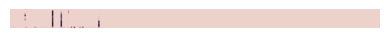

torch.Size([256, 32])


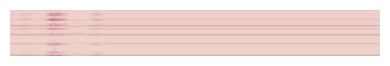

torch.Size([256, 32])


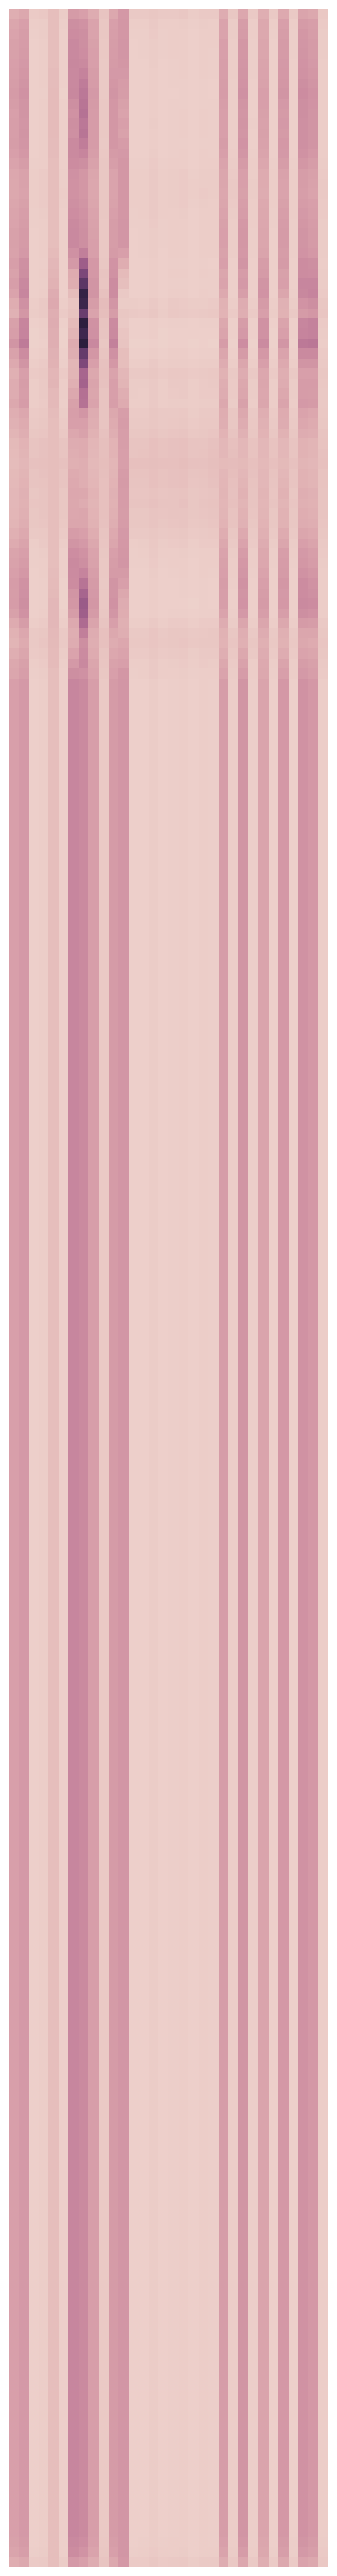

In [126]:
sample = datasets_matched["test"][0]
print(sample["labels"])
features = sample["features"]
print(features.shape)
visualize_features(features.T)
plt.show()

conv = (
    classifier.conv_layers[:-1](features.T.unsqueeze(0).to("cuda")).cpu().detach()[0].T
)
print(conv.shape)
visualize_features(conv.clip(0, 1).numpy().T)
plt.show()

ff = classifier.projection[:-1](conv.unsqueeze(0).to("cuda")).cpu().detach()[0]
print(ff.shape)
visualize_features(ff.numpy())
plt.show()

tensor(0)
torch.Size([256, 13])


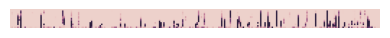

torch.Size([256, 32])


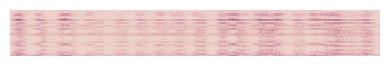

torch.Size([256, 32])


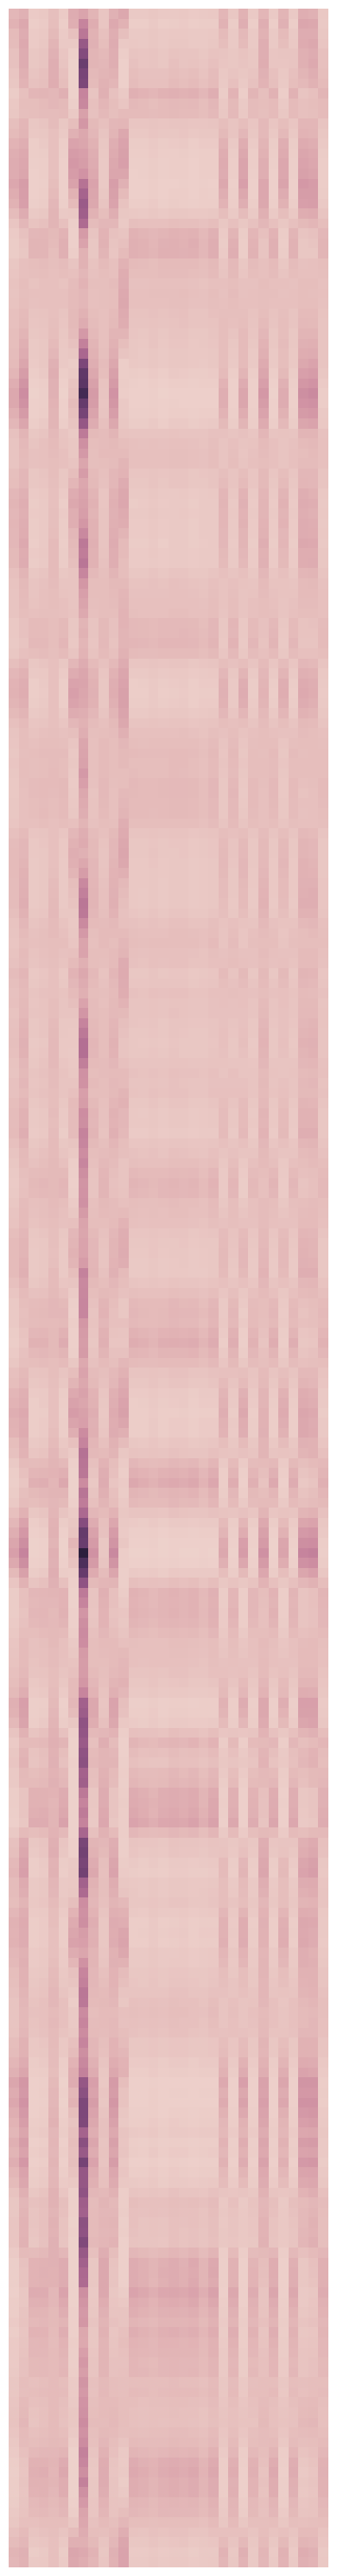

In [127]:
sample = datasets_matched["test"][2366]
print(sample["labels"])
features = sample["features"]
print(features.shape)
visualize_features(features.T)
plt.show()

conv = (
    classifier.conv_layers[:-1](features.T.unsqueeze(0).to("cuda")).cpu().detach()[0].T
)
print(conv.shape)
visualize_features(conv.clip(0, 1).numpy().T)
plt.show()

ff = classifier.projection[:-1](conv.unsqueeze(0).to("cuda")).cpu().detach()[0]
print(ff.shape)
visualize_features(ff.numpy())
plt.show()

In [128]:
raise RuntimeError()

RuntimeError: 

In [ ]:
import json

print(json.dumps(scores, indent=4))
with open("../logs/luminar/gpt2_first_128-3_epochs.json", "w") as f:
    json.dump(scores, f, indent=4)

In [ ]:
datasets = {}
for subset in [
    "blog_authorship_corpus",
    "student_essays",
    "cnn_news",
    "euro_court_cases",
    "house_of_commons",
    "arxiv_papers",
    "gutenberg_en",
    "en",
    "bundestag",
    "spiegel_articles",
    "gutenberg_de",
    "de",
]:
    config_name = f"{subset}-fulltext"
    datasets[config_name] = load_dataset(
        "liberi-luminaris/PrismAI-encoded-gpt2",
        config_name,
        token=HF_TOKEN,
        split="human+gpt_4o_mini",
    )

In [ ]:
dataset = load_dataset(
    "liberi-luminaris/PrismAI-fulltext", "cnn_news", split="human+gpt_4o_mini"
)
dataset_human = dataset.filter(lambda sample: sample["agent"] == "human")
source_ids = set(
    dataset_human.shuffle(seed=42).take(len(dataset_human) // 10 * 8)["id_source"]
)
dataset_train = dataset.filter(lambda sample: sample["id_source"] in source_ids)

In [ ]:
datasets_truncated = {}
for config_name, dataset in datasets.items():
    datasets_truncated[config_name] = dataset.with_format(
        "numpy", columns=["features"], output_all_columns=True
    ).map(
        lambda batch: {"features": batch["features"][:, :256]},
        batched=True,
    )

In [ ]:
datasets_considered = {
    key: value
    for key, value in datasets_truncated.items()
    if not key.startswith("de-") and not key.startswith("en-")
}

In [ ]:
import pandas as pd

domains = [
    "Web Blogs",
    "Essays",
    "CNN",
    "ECHR",
    "HoC",
    "arXiv",
    "Gutenberg$_{en}$",
    "Bundestag$_{de}$",
    "Spiegel$_{de}$",
    "Gutenberg$_{de}$",
    "All$_{en}$",
    "All$_{de}$",
]
name_map = {
    "blog_authorship_corpus": "Web Blogs",
    "student_essays": "Essays",
    "cnn_news": "CNN",
    "euro_court_cases": "ECHR",
    "house_of_commons": "HoC",
    "arxiv_papers": "arXiv",
    "gutenberg_en": "Gutenberg$_{en}$",
    "bundestag": "Bundestag$_{de}$",
    "spiegel_articles": "Spiegel$_{de}$",
    "gutenberg_de": "Gutenberg$_{de}$",
    "en": "All$_{en}$",
    "de": "All$_{de}$",
}

results = [
    {"domain": name_map[key.split("-", 1)[0]]}
    | {
        "f1": value["f1"],
        "acc": value["accuracy"],
        "auroc": value["auroc"],
    }
    for key, value in scores.items()
]
metric_df = (
    pd.DataFrame(results)
    .set_index("domain")
    .sort_index(key=lambda x: list(map(domains.index, x)))
)
print(metric_df.to_latex(float_format="%.3f", index=True))
metric_df

In [ ]:
# def run_detector(
#     detector: DetectorABC, datasets: dict[str, DatasetDict]
# ) -> dict[str, float]:
#     scores = {}
#     for config_name, ds in tqdm(datasets.items(), desc="Predicting on Datasets"):
#         dataset: Dataset = ds["test"].map(
#             detector.tokenize,
#             input_columns=["text"],
#             batched=True,
#             batch_size=1024,
#             desc="Tokenizing",
#         )
#         dataset = dataset.sort("length")
#         dataset = dataset.map(
#             detector.process,
#             batched=True,
#             batch_size=128,
#             desc="Predicting",
#         )

#         dataset_np = dataset.select_columns(["prediction", "label"]).with_format(
#             "numpy"
#         )

#         acc, f1, auroc = get_scores(dataset_np["label"], dataset_np["prediction"])
#         scores[config_name] = {"accuracy": acc, "f1": f1, "auroc": auroc}

#         acc, f1, auroc = get_scores(
#             dataset_np["label"],
#             dataset_np["prediction"],
#             calibrated=True,
#         )
#         scores[config_name] |= {
#             "accuracy_calibrated": acc,
#             "f1_calibrated": f1,
#             "auroc_calibrated": auroc,
#         }
#     return scores


In [ ]:
# def evaluate(model: LuminarClassifier, datasets: dict[str, DatasetDict]) -> dict:
#     scores = {}
#     for config_name, dataset in tqdm(datasets.items(), desc="Evaluating", leave=False):
#         ds = (
#             dataset["test"]
#             .with_format("torch", ["features"])
#             .map(model.process, batched=True, batch_size=32, desc="Predicting")
#         )
#         dataset_np = ds.select_columns(["prediction", "label"]).with_format("numpy")

#         acc, f1, auroc = get_scores(dataset_np["label"], dataset_np["prediction"])
#         scores[config_name] = {
#             "accuracy": acc,
#             "f1": f1,
#             "auroc": auroc,
#         }

#         acc, f1, auroc = get_scores(
#             dataset_np["label"],
#             dataset_np["prediction"],
#             calibrated=True,
#         )
#         scores[config_name] |= {
#             "accuracy_calibrated": acc,
#             "f1_calibrated": f1,
#             "auroc_calibrated": auroc,
#         }

#     return scores